# Start

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import glob
import os
from os import walk
from os import path
from bs4 import BeautifulSoup
import requests
from pandas.api.types import CategoricalDtype
import varname
import math
from pandas import Index
import psutil

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

os.chdir('C:\Świetlik\KU Leuven\MT Masters thesis\Data')  
mypath =os.getcwd()

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')

# Functions

In [2]:
# Displaying all rows of the object
def show_all(output):
    option_value = pd.get_option('display.max_rows')
    pd.set_option('display.max_rows', None)
    try:
        display(output)
    finally:
        pd.set_option('display.max_rows', option_value)
        
def show_wide(output):
    option_value = pd.get_option('display.width')
    pd.set_option('display.width', None)
    try:
        display(output)
    finally:
        pd.set_option('display.width', option_value)
        
# No scientific notation
def show_nosci(output):
    option_value = pd.get_option('display.float_format')
    pd.set_option('display.float_format', lambda x: '%.0f' % x)
    try:
        display(output)
    finally:
        pd.set_option('display.float_format', option_value)
        
# turn 
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def interact(data, list1, list2):
    col_to_zip = []
    for i in list1:
        for j in list2:
            col_to_zip.append([i,j])
    inter_col=[]
    for i,j in col_to_zip:
        data[i+'_'+j] = data[i].mul(data[j])
        inter_col.append(i+'_'+j)
    return data[inter_col]

def w_bins(lower_bound, width, max_val):
    ceiling = math.ceil((max_val-lower_bound) / width)*width+1
    return list(range(lower_bound, ceiling, width))

# Glob & Cat

In [3]:
# Lisy
lisy = list(range(2004, 2019))
lisy2 = list(range(2004, 2019,2))

# Categories
klasa_miejscowości_order = ['500 tys. mieszkańców i więcej','200 - 499 tys. mieszkańców','100 - 199 tys. mieszkańców','20 - 99 tys. mieszkańców','poniżej 20 tys. mieszkańców','wieś']
klasa_miejscowości_type = CategoricalDtype(categories=klasa_miejscowości_order, ordered=True)

województwo_order = ['dolnośląskie', 'kujawsko-pomorskie', 'lubelskie', 'lubuskie', 'mazowieckie', 'małopolskie', 'opolskie', 'podkarpackie', 'podlaskie', 'pomorskie', 'śląskie', 'świętokrzyskie', 'warmińsko-mazurskie', 'wielkopolskie', 'zachodniopomorskie', 'łódzkie']
województwo_type = CategoricalDtype(categories=województwo_order, ordered=True)

rok_bodowy_order = ['1800, 1945', '1946, 1960', '1961, 1980', '1981, 1995', '1996, 2006', '2007, 2010', '2011, 2018']
rok_budowy_type = CategoricalDtype(categories=rok_bodowy_order, ordered=True)

sieci_order = ['nie_ma', 'jest']
sieć_type = CategoricalDtype(categories=sieci_order, ordered=True)

fua_order = ['fua_stolica_województwa', 'fua_inne_miasto', 'poza_fua']
fua_type = CategoricalDtype(categories=fua_order, ordered=True)

fua2_order = ['stolica', 'stolica_województwa', 'fua_stolica_województwa', 'inne_miasto', 'fua_inne_miasto', 'poza_fua']
fua2_type = CategoricalDtype(categories=fua2_order, ordered=True)

strefa_miasta_order = ['Pośrednia', 'Peryferyjna', 'Śródmiejska', 'Centralna']
strefa_miasta_type = CategoricalDtype(categories=strefa_miasta_order, ordered=True)

# Deflator GDP

In [4]:
# Deflator DGP
deflator = pd.read_excel('Deflator GDP/GDP Deflator.xlsx').set_index('year').deflator

# BBGD import

In [5]:
# making sample bbgd with proper categories

# bbgd.sample(50000).to_csv('BBGD/preprocessed_data/BBGD_temp.csv')
bbgd = pd.read_csv('BBGD/preprocessed_data/BBGD_temp.csv')

# categories
bbgd.klasa_miejscowości = bbgd.klasa_miejscowości.astype(klasa_miejscowości_type)
bbgd.rok_budowy = bbgd.rok_budowy.astype(rok_budowy_type)
bbgd.województwo = bbgd.województwo.astype(województwo_type)
bbgd.sieć_gazowa = bbgd.sieć_gazowa.astype(sieć_type)
bbgd.sieć_ciepłownicza = bbgd.sieć_ciepłownicza.astype(sieć_type)

# Adding missing variables for estimation
bbgd['constant'] = 1
bbgd['predict_cena_m2'] = np.nan
bbgd['waga_norm'] = bbgd.waga

weights_sum = bbgd.groupby('rok').waga.sum()
for i in lisy2:
    bbgd.loc[bbgd.rok==i, 'waga_norm'] = bbgd.loc[bbgd.rok==i, 'waga_norm'].div(weights_sum[i])

# LM

## LM import

In [5]:
lm_var_to_category = ['źródło', 'waluta', 'województwo', 'typ_nieruchomości', 'strefa_miasta', 'prawo_do_gruntu',
                      'prawo_do_lokalu', 'rodzaj_budynku', 'konstrukcja_budynku', 'klasa_miejscowości']

# lm = pd.read_csv('AMRON/LM_XLS/LM_temp.csv')
lm = pd.read_csv('AMRON/LM_XLS/LM.csv')
lm[lm_var_to_category] = lm[lm_var_to_category].astype('category')

# Ordered class of locality
lm.klasa_miejscowości = lm.klasa_miejscowości.astype(klasa_miejscowości_type)

# Ordered voivodeship
lm.województwo = lm.województwo.astype(województwo_type)

# Changing date to year
lm['rok'] = lm.data.apply(lambda x: x[:4])
lm['rok'] = lm['rok'].astype('int64')
lm.drop('data', axis=1, inplace=True)
lm.drop(lm.loc[lm.rok>2019].index, axis=0, inplace=True)

# Adjusting prices to 2010 PLN
lm['deflator'] = lm.rok
lm.deflator = lm.deflator.apply(lambda x: deflator[x])
lm[['deflator', 'rok']]
lm.cena = lm.cena / lm.deflator *100

# Adding świętokrzyskie label to the data
powiaty_świętokrzyskie = ['Kielce', 'skarżyski', 'ostrowiecki', 'starachowicki', 'konecki', 'jędrzejowski',
                          'buski', 'sandomierski', 'staszowski', 'pińczowski', 'kielecki', 'włoszczowski',
                          'kazimierski', 'opatowski', 'konecki']
lm.loc[lm.powiat.isin(powiaty_świętokrzyskie), 'województwo'] = 'świętokrzyskie'

# New variable Primary and secondary market
lm.loc[lm.źródło.isin(['Umowa sprzedaży rynek pierwotny', 'Przedwstępna umowa sprzedaży rynek pierwotny']), 'rynek'] = 'pierwotny'
lm.loc[lm.źródło.isin(['Umowa sprzedaży rynek wtórny', 'Przedwstępna umowa sprzedaży rynek wtórny']), 'rynek'] = 'wtórny'
lm['rynek'] = lm['rynek'].astype('category')

# Remove foreign currency, remove waluta as varaible
lm.drop(lm[lm.waluta != 'PLN'].index, inplace=True)
lm.drop('waluta', axis =1, inplace=True)

# Synhronize ownership right
lm.prawo_do_lokalu = lm.prawo_do_lokalu.astype('object')
lm.loc[lm.prawo_do_lokalu.isin(['Brak informacji','Prawo użytkowania']), 'prawo_do_lokalu'] = np.nan
lm.loc[lm.prawo_do_lokalu == 'Prawo własności', 'prawo_do_lokalu'] = 'własnościowe'
lm.loc[lm.prawo_do_lokalu == 'Spółdzielcze własnościowe prawo do lokalu', 'prawo_do_lokalu'] = 'spółdzielcze'
lm.prawo_do_lokalu = lm.prawo_do_lokalu.astype('category')

# Categorize year of construction
lm = lm.loc[lm.rok_budowy>1850]
bins = [1800, 1946, 1961, 1981, 1996, 2007, 2011, 2018]
lm['rok_budowy'] = pd.cut(lm['rok_budowy'], bins=bins, precision=0)
lm['rok_budowy'] = lm['rok_budowy'].apply(lambda x: str(x.left)+', '+str(x.right-1 if x.right<2018 else x.right)).astype(rok_budowy_type)


# # Recategorizing the urban arrangement 
# bm.loc[bm.rodzaj_zabudowy.isin(['Brak informacji', 'Rekreacyjna', 'Wielorodzinna']), 'rodzaj_zabudowy'] = np.nan
# bm.loc[bm.rodzaj_zabudowy == 'Rezydencja', 'rodzaj_zabudowy'] = 'Wolnostojąca'

# remove transactions on not yet build
cat_bud = lm.rok_budowy.unique().dropna()
to_drop = Index([])
for cat in cat_bud:
    to_drop = pd.Index.append(to_drop, lm.loc[(lm.rok_budowy == cat) & (lm.rok < int(cat[:4]))].index)
lm.drop(to_drop, axis=0, inplace=True)

# FUA (Functional Urban Area)
lm.fua_cat.fillna('poza_fua', inplace=True)
lm.fua_cat = lm.fua_cat.astype(fua_type)
lm.fua_cat2.fillna('poza_fua', inplace=True)
lm.fua_cat2 = lm.fua_cat2.astype(fua2_type)

lm.loc[lm.strefa_miasta == 'Brak informacji', 'strefa_miasta'] = np.nan
lm.strefa_miasta = lm.strefa_miasta.astype(strefa_miasta_type)

# Remove outliers
lm = lm.loc[(lm.cena>10000) & (lm.cena<10000000)]
lm.loc[(lm.liczba_pokoi > 7) | (lm.liczba_pokoi ==0), 'liczba_pokoi'] = np.nan
lm['liczba_pokoi'] = lm['liczba_pokoi'].astype('category')
lm = lm.loc[(lm.powierzchnia_użytkowa < 300) & (lm.powierzchnia_użytkowa > 10)]
lm.loc[lm.piętro.isin([99, 999, 9999]), 'piętro'] = np.nan
lm.loc[lm.liczba_pięter.isin([99, 999, 9999, 1111, 98]), 'liczba_pięter'] = np.nan
lm = lm.loc[lm.piętro<30]
lm = lm.loc[lm.liczba_pięter<30]

# For regression
# Constant
lm['constant'] = 1
# Log price
lm['ln_cena'] = np.log(lm.cena)
# Price of m^2
lm['cena_m2'] = lm.cena.div(lm.powierzchnia_użytkowa)
lm = lm[(lm.cena_m2 < 30000) & (lm.cena_m2>150)]
# Log price of m^2
lm['ln_cena_m2'] = np.log(lm.cena_m2)
# Log surface
lm['ln_powierzchnia_użytkowa'] = np.log(lm.powierzchnia_użytkowa)

## LM describe

## LM AP pi

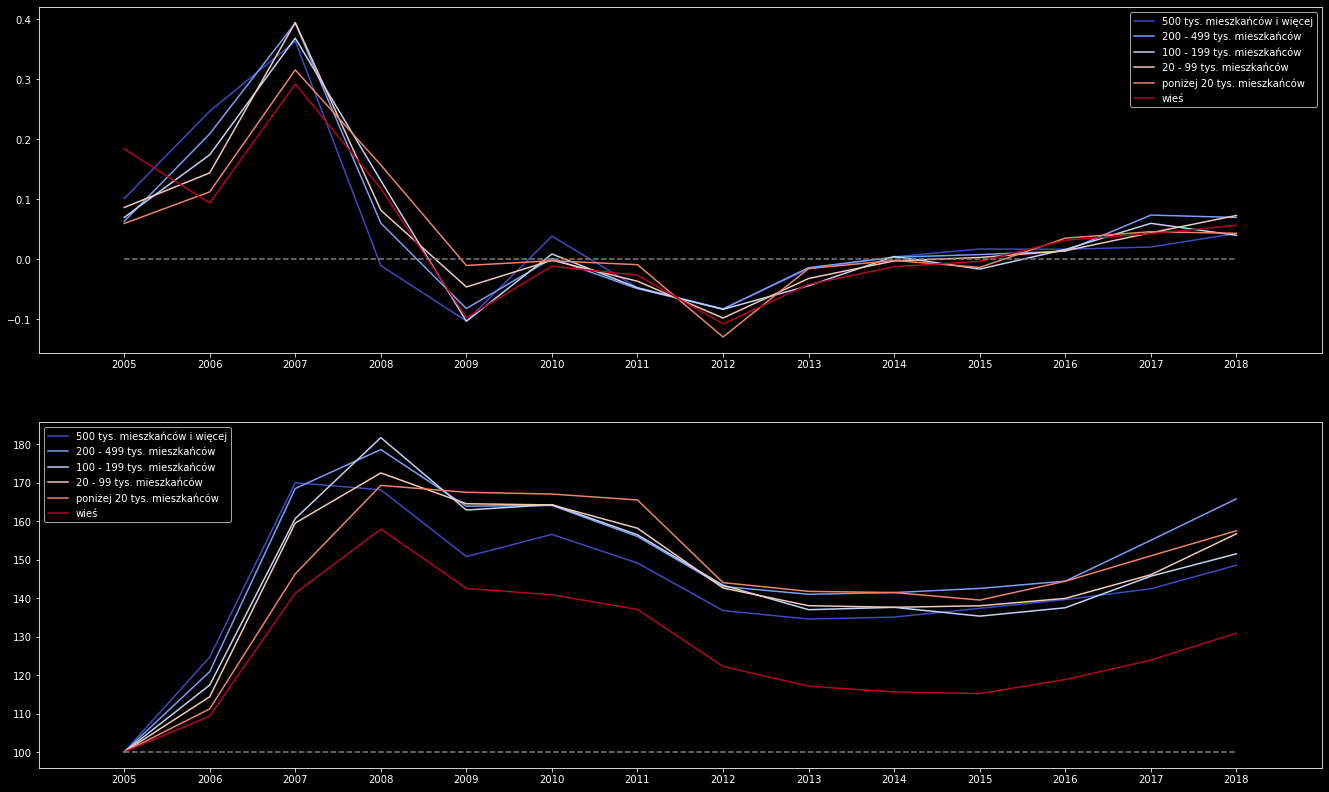

In [19]:
# For whole PL and for different levels of urbanization
iterations = []
for i in range(len(lisy)-1):
    iterations.append([lisy[i], lisy[i+1]])

data = lm
Y = ['ln_cena_m2']
X_num = ['constant','powierzchnia_użytkowa']
X_cat = ['rok','województwo','rok_budowy','klasa_miejscowości']

# Whole PL
index_PL =pd.DataFrame(index=lisy[1:])
for j in range(len(iterations)):
    i =iterations[j]
    temp_data = data.loc[data.rok.isin(i)]
    dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
    exog = temp_data[X_num].join(dum, how='left')
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    time_param = reg.params['rok_'+str(i[1])]
    index_PL.at[lisy[1:][j], 'PL'] = time_param

# By levels of urbanization
X_cat.remove('klasa_miejscowości')
urb_lev_index = pd.DataFrame(index=lisy[1:])
observations = pd.DataFrame(index=lisy[1:])
for klasa in klasa_miejscowości_order:
    prams_collector = []
    nobs_collector = []
    for i in iterations:
        temp_data = data.loc[(data.rok.isin(i)) & (data.klasa_miejscowości == klasa)]
        dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
        exog = temp_data[X_num].join(dum, how='left')
        reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
#         print(reg.summary())
        params = reg.params[2]
        prams_collector.append(params)    
        nobs_collector.append(reg.nobs)
    urb_lev_index[klasa] = prams_collector
    observations[klasa] = nobs_collector
# exp_indexes = klas_collector.applymap(lambda x: math.exp(x))

# Plot
fig, [ax1,ax2] = plt.subplots(2,figsize=(23,14))
urb_lev_index.plot(cmap='coolwarm', ax=ax1)
# index_PL.plot(color='white',  label='PL', ax=ax1)
ax1.plot(list(range(2005,2019)), [0]*len(index_PL),'--', color='grey')
ax1.set_xlim(2004, 2019)
ax1.set_xticks(list(range(2005, 2019)))

# Relative_pure_price_index base 2004
# relative_urb_lev_index = pd.DataFrame(index=lisy, columns=klasa_miejscowości_order)
# relative_urb_lev_index.loc[2004,:] =100
# for i in urb_lev_index.index:
#     relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])
# relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# # index_PL.plot(color='b', label='PL', ax=ax)
# ax2.plot(list(range(2004,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
# ax2.set_xlim(2003, 2019)
# _=ax2.set_xticks(range(2004, 2019))

# Relative_pure_price_index base 2005
relative_urb_lev_index = pd.DataFrame(index=lisy[1:], columns=klasa_miejscowości_order)
relative_urb_lev_index.loc[2005,:] =100

for i in urb_lev_index.index[1:]:
    relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])

relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# index_PL.plot(color='b', label='PL', ax=ax)
ax2.plot(list(range(2005,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
ax2.set_xlim(2004, 2019)
_=ax2.set_xticks(range(2005, 2019))

# Mean of inde over the years
# d = urb_lev_index.mean()
# d['PL'] = np.mean(index_PL)
# print(d)
# observations
# relative_urb_lev_index

In [ ]:
# Price Index By FUA
# For whole PL and for FUA
iterations = []
for i in range(len(lisy)-1):
    iterations.append([lisy[i], lisy[i+1]])

data = lm
Y = ['ln_cena_m2']
X_num = ['constant','powierzchnia_użytkowa']
X_cat = ['rok','województwo','rok_budowy']

# Whole PL
index_PL = []
for i in iterations:
    temp_data = data.loc[data.rok.isin(i)]
    dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
    exog = temp_data[X_num].join(dum, how='left')
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    time_param = reg.params['rok_'+str(i[1])]
    index_PL.append(time_param)

# By levels of urbanization
# X_cat.remove('klasa_miejscowości')
urb_lev_index = pd.DataFrame(index=lisy[1:])
observations = pd.DataFrame(index=lisy[1:])
for klasa in fua2_order:
    prams_collector = []
    nobs_collector = []
    for i in iterations:
        temp_data = data.loc[(data.rok.isin(i)) & (data.fua_cat2 == klasa)]
        dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
        exog = temp_data[X_num].join(dum, how='left')
#         exog = exog.loc[:, (exog != 0).any(axis=0)].dropna(axis=1)
        reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
        params = reg.params[2]
        prams_collector.append(params)    
        nobs_collector.append(reg.nobs)
    urb_lev_index[klasa] = prams_collector
    observations[klasa] = nobs_collector
# exp_indexes = klas_collector.applymap(lambda x: math.exp(x))

# Plot
fig, [ax1,ax2] = plt.subplots(2,figsize=(23,14))
urb_lev_index.plot(cmap='coolwarm', ax=ax1)
# index_PL.plot(color='white',  label='PL', ax=ax1)
ax1.plot(list(range(2005,2019)), [0]*len(index_PL),'--', color='grey')
ax1.set_xlim(2004, 2019)
_=ax1.set_xticks(list(range(2005, 2019)))


# Relative_pure_price_index
relative_urb_lev_index = pd.DataFrame(index=lisy, columns=fua2_order)
relative_urb_lev_index.loc[2004,:] =100

for i in urb_lev_index.index:
    relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])

relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# index_PL.plot(color='b', label='PL', ax=ax)
ax2.plot(list(range(2004,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
ax2.set_xlim(2003, 2019)
_=ax2.set_xticks(range(2004, 2019))
ax2.set_title('')

# Mean of inde over the years
# d = urb_lev_index.mean()
# d['PL'] = np.mean(index_PL)
# print(d)
# observations

In [21]:
relative_urb_lev_index

,poza_fua,fua_inne_miasto,inne_miasto,fua_stolica_województwa,stolica_województwa,stolica
2004,100,100,100,100,100,100
2005,18891.5,4778.82,18995.9,29728.3,30454.7,47144.4
2006,4.51643e+06,1.58276e+06,5.94102e+06,1.64447e+07,2.58891e+07,6.18023e+07
2007,4.48932e+09,1.47469e+09,6.87388e+09,2.69994e+10,4.53453e+10,1.63845e+11
2008,1.16112e+12,1.49242e+11,3.0867e+12,9.16383e+12,1.63519e+12,8.69319e+12
2009,-5.91871e+13,-1.81784e+13,-9.41653e+14,-4.22652e+15,-9.67389e+14,-8.62826e+15
2010,8.24313e+14,-2.77343e+15,5.11965e+16,2.67648e+17,-1.77057e+17,-1.80037e+18
2011,-8.15486e+16,1.14282e+17,-7.55493e+18,-5.69175e+19,2.92177e+19,7.8639e+20
2012,2.92302e+19,-5.1099e+19,1.58908e+21,1.78849e+22,-1.24199e+22,-3.88242e+23
2013,-1.00854e+20,-7.14891e+20,-1.94902e+23,-2.61587e+24,4.30961e+23,6.03788e+25


# BM

## BM import

In [20]:
bmj_var_to_category = ['źródło', 'waluta', 'typ_nieruchomości', 'strefa_miasta', 'prawo_do_gruntu',
                       'prawo_do_budynku', 'działka_nieuzbrojona/działka_uzbrojona', 'zagęszczenie_zabudowy',
                       'rodzaj_zabudowy', 'modernizacje', 'kształt', 'konstrukcja_budynku',
                       'kanalizacj_bezodpływowa', 'kanalizacja_sieciowa', 'lokalne_ujęcie_wody',
                       'sieć_elektroenergetyczna', 'sieć_wodociągowa']

In [33]:

bm = pd.read_csv('AMRON/BMJ_XLS/bmj.csv')
# bm = pd.read_csv('AMRON/BMJ_XLS/BMJ_temp.csv')
bm[bmj_var_to_category] = bm[bmj_var_to_category].astype('category')

# Ordered categories
bm.klasa_miejscowości = bm.klasa_miejscowości.astype(klasa_miejscowości_type)
bm.województwo = bm.województwo.astype(województwo_type)
# bm.sieć_gazowa = bm.sieć_gazowa.astype(sieć_type)
# bm.sieć_ciepłownicza = bm.sieć_ciepłownicza.astype(sieć_type)

# Changing date to year
bm['rok'] = bm.data.apply(lambda x: x[:4])
bm['rok'] = bm['rok'].astype('int64')
bm.drop('data', axis=1, inplace=True)
bm.drop(bm.loc[bm.rok>2019].index, axis=0, inplace=True)

# Adjusting prices to 2010 PLN
bm['deflator'] = bm.rok
bm.deflator = bm.deflator.apply(lambda x: deflator[x])
bm[['deflator', 'rok']]
bm.cena = bm.cena / bm.deflator *100

# New variable Primary and secondary market
bm.loc[bm.źródło.isin(['Umowa sprzedaży rynek pierwotny', 'Przedwstępna umowa sprzedaży rynek pierwotny']), 'rynek'] = 'pierwotny'
bm.loc[bm.źródło.isin(['Umowa sprzedaży rynek wtórny', 'Przedwstępna umowa sprzedaży rynek wtórny']), 'rynek'] = 'wtórny'
bm.rynek = bm.rynek.astype('category')

# Remove foreign currency, remove waluta as varaible
bm.drop(bm[bm.waluta != 'PLN'].index, inplace=True)
bm.drop('waluta', axis =1, inplace=True)

# Categorize year of construction
bm = bm.loc[bm.rok_budowy>1850]
bins = [1800, 1946, 1961, 1981, 1996, 2007, 2011, 2018]
bm['rok_budowy'] = pd.cut(bm['rok_budowy'], bins=bins, precision=0)
bm['rok_budowy'] = bm['rok_budowy'].apply(lambda x: str(x.left)+', '+str(x.right-1 if x.right<2018 else x.right)).astype(rok_budowy_type)

# Adding building type as in bbgd
bm['rodzaj_budynku'] = np.nan
bm.loc[bm.rodzaj_zabudowy.isin(['Bliźniacza', 'Szeregowa']), 'rodzaj_budynku'] = 'szeregowy i bliźniaczy'
bm.loc[bm.rodzaj_zabudowy.isin(['Wolnostojąca', 'Rezydencja']), 'rodzaj_budynku'] = 'wolnostojący'
bm.rodzaj_budynku = bm.rodzaj_budynku.astype('category')

# remove transactions on not yet build
cat_bud = bm.rok_budowy.unique().dropna()
to_drop = Index([])
for cat in cat_bud:
    to_drop = pd.Index.append(to_drop, bm.loc[(bm.rok_budowy == cat) & (bm.rok < int(cat[:4]))].index)
bm.drop(to_drop, axis=0, inplace=True)

# Simplyfy utilities
for sieć in ['sieć_ciepłownicza', 'sieć_elektroenergetyczna', 'sieć_gazowa', 'sieć_wodociągowa', 'lokalne_ujęcie_wody',
             'kanalizacj_bezodpływowa', 'kanalizacja_sieciowa',]:
    bm['temp'] = np.nan
    bm.loc[bm[sieć].isin(['Na działce lub przy granicy działki', 'Możliwość podłączenia']), 'temp'] =  'jest'
    bm.loc[bm[sieć].isin(['Nie dotyczy', 'Brak możliwości podłączenia']), 'temp'] =  'nie_ma'
    bm[sieć] = bm['temp'].astype(sieć_type)

# FUA (Functional Urban Area)
bm.fua_cat.fillna('poza_fua', inplace=True)
bm.fua_cat = bm.fua_cat.astype(fua_type)
bm.fua_cat2.fillna('poza_fua', inplace=True)
bm.fua_cat2 = bm.fua_cat2.astype(fua2_type)

bm.loc[bm.strefa_miasta == 'Brak informacji', 'strefa_miasta'] = np.nan
bm.strefa_miasta = bm.strefa_miasta.astype(strefa_miasta_type)

# Remove outliers
bm = bm.loc[(bm.cena>10000) & (bm.cena<5000000)]
bm = bm[(bm.powierzchnia_użytkowa < 1000) & (bm.powierzchnia_użytkowa>20)]

# For regression
# Constant
bm['constant'] = 1
# Log price
bm['ln_cena'] = np.log(bm.cena)
# Price of m^2
bm['cena_m2'] = bm.cena.div(bm.powierzchnia_użytkowa)
bm = bm[(bm.cena_m2 < 25000) & (bm.cena_m2>150)]
# Log price of m^2
bm['ln_cena_m2'] = np.log(bm.cena_m2)
# Log surface
bm['ln_powierzchnia_użytkowa'] = np.log(bm.powierzchnia_użytkowa)

## BM describe

## BM AP pi

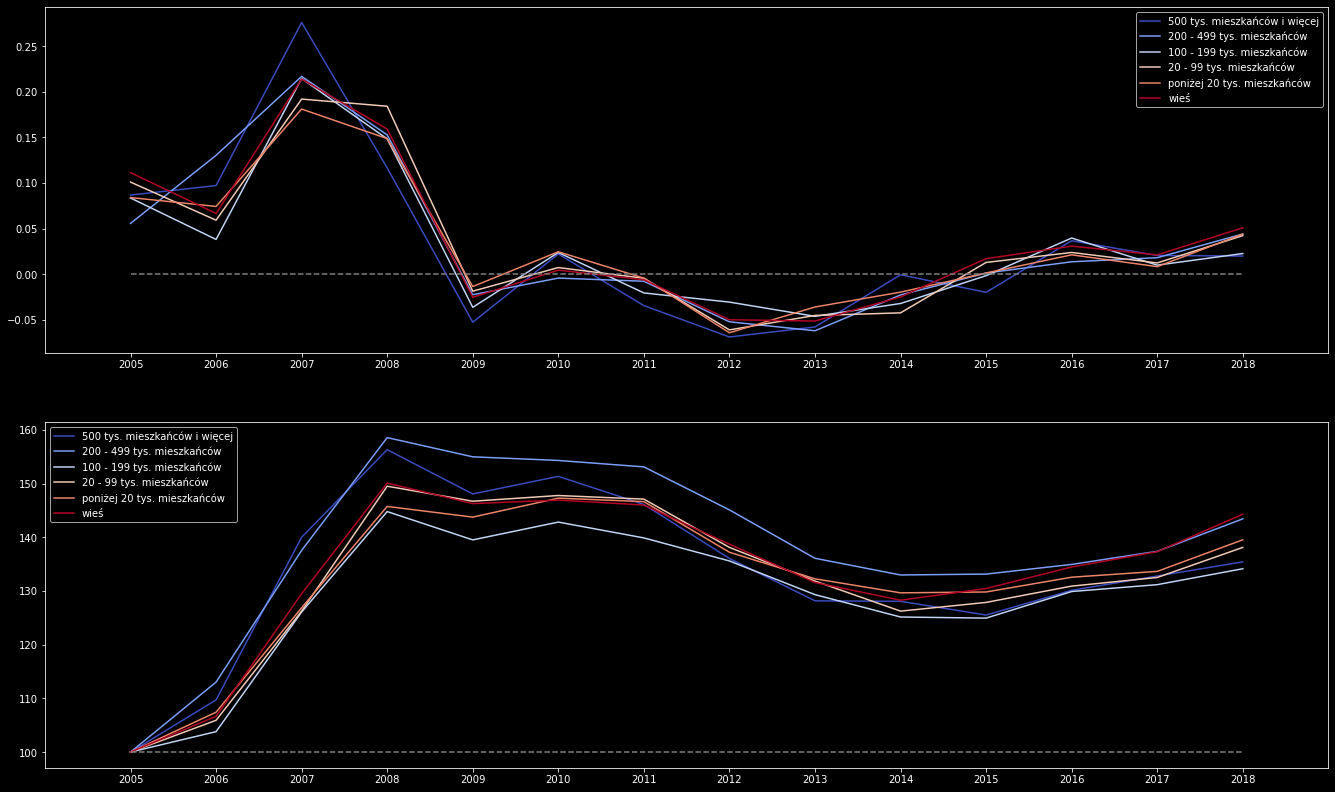

In [34]:
# For whole PL and for different levels of urbanization
iterations = []
for i in range(len(lisy)-1):
    iterations.append([lisy[i], lisy[i+1]])

data = bm
Y = ['ln_cena_m2']
X_num = ['constant','powierzchnia_użytkowa']
X_cat = ['rok','województwo','rok_budowy','klasa_miejscowości', 'fua_cat2']

# Whole PL
index_PL =pd.DataFrame(index=lisy[1:])
for i in iterations:
    temp_data = data.loc[data.rok.isin(i)] 
    dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
    exog = temp_data[X_num].join(dum, how='left')
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    time_param = reg.params['rok_'+str(i[1])]
    index_PL.at[lisy[1:][j], 'PL'] = time_param

# By levels of urbanization
X_cat.remove('klasa_miejscowości')
urb_lev_index = pd.DataFrame(index=lisy[1:])
observations = pd.DataFrame(index=lisy[1:])
R2s = pd.DataFrame()
bm_ap_models = []
for klasa in klasa_miejscowości_order:
    prams_collector = []
    nobs_collector = []
    R2_colector =[]
    for i in iterations:
        temp_data = data.loc[(data.rok.isin(i)) & (data.klasa_miejscowości == klasa)]
        dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
        exog = temp_data[X_num].join(dum, how='left')
        reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
#         print(reg.summary())
        bm_ap_models.append(reg)
        params = reg.params[2]
        prams_collector.append(params)    
        nobs_collector.append(reg.nobs)
        R2_colector.append(reg.rsquared)
    R2s[klasa] = R2_colector    
    urb_lev_index[klasa] = prams_collector
    observations[klasa] = nobs_collector
# exp_indexes = klas_collector.applymap(lambda x: math.exp(x))

# Plot
# fig, ax = plt.subplots(figsize=(23,7))
# urb_lev_index.plot(cmap='YlOrRd', ax=ax)
# ax.plot(index_PL, 'b', label='PL')
# ax.plot([0]*len(index_PL),'--', color='grey')


fig, [ax1,ax2] = plt.subplots(2,figsize=(23,14))
urb_lev_index.plot(cmap='coolwarm', ax=ax1)
# index_PL.plot(color='white',  label='PL', ax=ax1)
ax1.plot(list(range(2005,2019)), [0]*len(index_PL),'--', color='grey')
ax1.set_xlim(2004, 2019)
ax1.set_xticks(list(range(2005, 2019)))

# # Relative_pure_price_index base 2004
# relative_urb_lev_index = pd.DataFrame(index=lisy, columns=klasa_miejscowości_order)
# relative_urb_lev_index.loc[2004,:] =100
# for i in urb_lev_index.index:
#     relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])
# relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# # index_PL.plot(color='b', label='PL', ax=ax)
# ax2.plot(list(range(2004,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
# ax2.set_xlim(2003, 2019)
# _=ax2.set_xticks(range(2004, 2019))


# Relative_pure_price_index base 2005
relative_urb_lev_index = pd.DataFrame(index=lisy[1:], columns=klasa_miejscowości_order)
relative_urb_lev_index.loc[2005,:] =100

for i in urb_lev_index.index[1:]:
    relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])

relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# index_PL.plot(color='b', label='PL', ax=ax)
ax2.plot(list(range(2005,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
ax2.set_xlim(2004, 2019)
_=ax2.set_xticks(range(2005, 2019))

# Mean of inde over the years
# d = urb_lev_index.mean()
# d['PL'] = np.mean(index_PL)
# print(d)
# Number of observation in each period and level of urbanization
# observations
# R2s

In [ ]:
# BM AD pi Regression results
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
results_table = summary_col(results=bm_ap_models,
                            float_format='%0.2f',
                            stars = True,
                            model_names= lisy,
                            info_dict=info_dict)
results_table.add_title('BM AP pi _ by level of urbanization')
results_table

Text(0.5, 1.0, 'BM Real Price Index, base 2005')

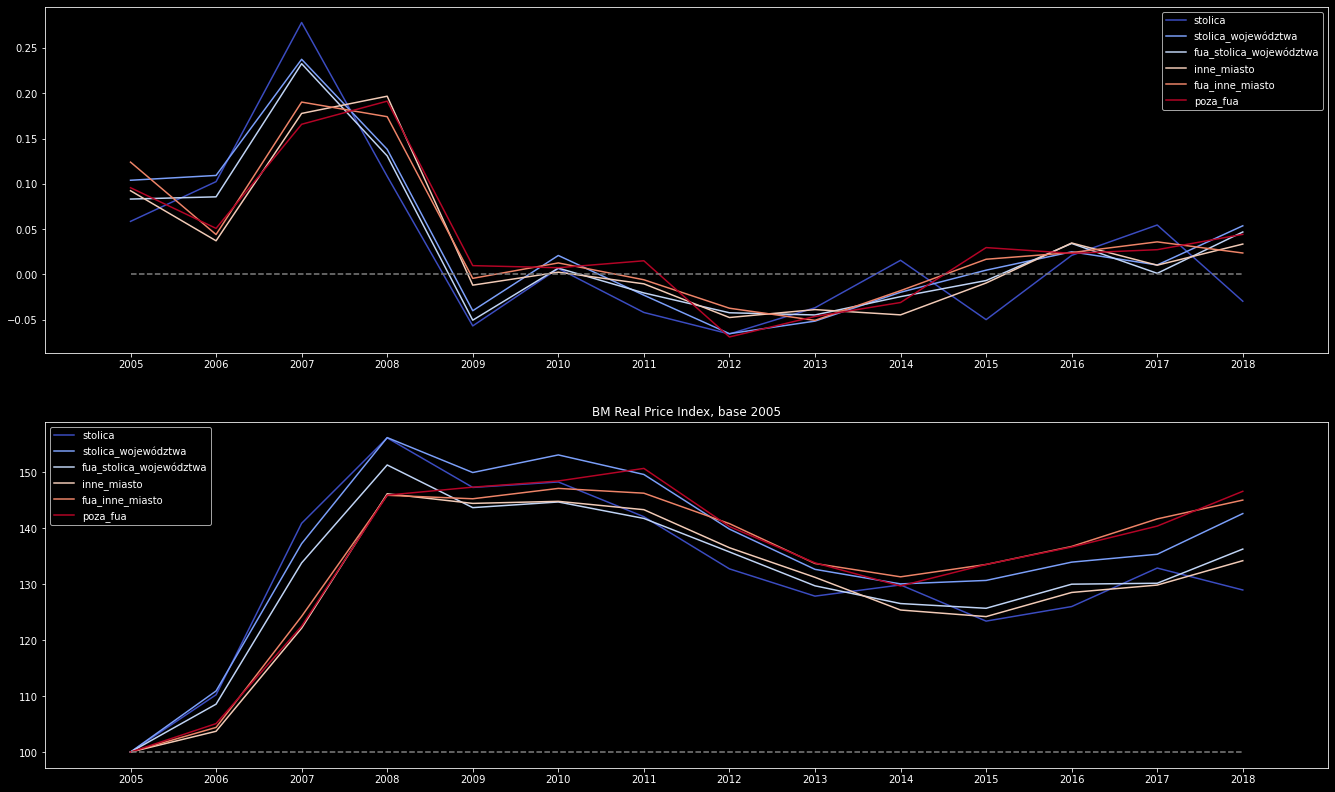

In [39]:
# For whole PL and for different levels of urbanization
iterations = []
for i in range(len(lisy)-1):
    iterations.append([lisy[i], lisy[i+1]])

data = bm
Y = ['ln_cena_m2']
X_num = ['constant','powierzchnia_użytkowa']
X_cat = ['rok','województwo','rok_budowy']
# 'klasa_miejscowości'

# Whole PL
index_PL = []
for i in iterations:
    temp_data = data.loc[data.rok.isin(i)] 
    dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
    exog = temp_data[X_num].join(dum, how='left')
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    time_param = reg.params['rok_'+str(i[1])]
    index_PL.append(time_param)

# By levels of urbanization
# X_cat.remove('klasa_miejscowości')
urb_lev_index = pd.DataFrame(index=lisy[1:])
observations = pd.DataFrame(index=lisy[1:])
R2s = pd.DataFrame()
for klasa in fua2_order:
    prams_collector = []
    nobs_collector = []
    R2_colector =[]
    for i in iterations:
        temp_data = data.loc[(data.rok.isin(i)) & (data.fua_cat2 == klasa)]
        dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
        exog = temp_data[X_num].join(dum, how='left')
        reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
#         print(reg.summary())
        params = reg.params[2]
        prams_collector.append(params)    
        nobs_collector.append(reg.nobs)
        R2_colector.append(reg.rsquared)
    R2s[klasa] = R2_colector   
    urb_lev_index[klasa] = prams_collector
    observations[klasa] = nobs_collector
# exp_indexes = klas_collector.applymap(lambda x: math.exp(x))

# Plot
fig, [ax1,ax2] = plt.subplots(2,figsize=(23,14))
urb_lev_index.plot(cmap='coolwarm', ax=ax1)
# index_PL.plot(color='white',  label='PL', ax=ax1)
ax1.plot(list(range(2005,2019)), [0]*len(index_PL),'--', color='grey')
ax1.set_xlim(2004, 2019)
_=ax1.set_xticks(list(range(2005, 2019)))


# Relative_pure_price_index base 2004
# relative_urb_lev_index = pd.DataFrame(index=lisy, columns=fua2_order)
# relative_urb_lev_index.loc[2004,:] =100
# for i in urb_lev_index.index:
#     relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])
# relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# # index_PL.plot(color='b', label='PL', ax=ax)
# ax2.plot(list(range(2004,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
# ax2.set_xlim(2003, 2019)
# _=ax2.set_xticks(range(2004, 2019))

# Relative_pure_price_index base 2005
relative_urb_lev_index = pd.DataFrame(index=lisy[1:], columns=fua2_order)
relative_urb_lev_index.loc[2005,:] =100

for i in urb_lev_index.index[1:]:
    relative_urb_lev_index.loc[i,:] = relative_urb_lev_index.loc[i-1,:] * (1+ urb_lev_index.loc[i,:])

relative_urb_lev_index.plot(cmap='coolwarm', ax=ax2)
# index_PL.plot(color='b', label='PL', ax=ax)
ax2.plot(list(range(2005,2019)), [100]*len(relative_urb_lev_index),'--', color='grey')
ax2.set_xlim(2004, 2019)
_=ax2.set_xticks(range(2005, 2019))
ax2.set_title('BM Real Price Index, base 2005')

# Mean of inde over the years
# d = urb_lev_index.mean()
# d['PL'] = np.mean(index_PL)
# print(d)
# Number of observation in each period and level of urbanization
# observations
# R2s

# MM AP pi

In [26]:
# Joining lm and bm data sets
var_for_mm = ['cena_m2', 'rok','województwo','rok_budowy','klasa_miejscowości', 'constant','powierzchnia_użytkowa','typ_nieruchomości']
mm = pd.concat([lm[var_for_mm], bm[var_for_mm]], ignore_index=True)

500 tys. mieszkańców i więcej    198.622060
200 - 499 tys. mieszkańców       154.521852
100 - 199 tys. mieszkańców        96.004482
20 - 99 tys. mieszkańców         103.703786
poniżej 20 tys. mieszkańców       84.848098
wieś                              92.252505
PL                               127.211167
dtype: float64


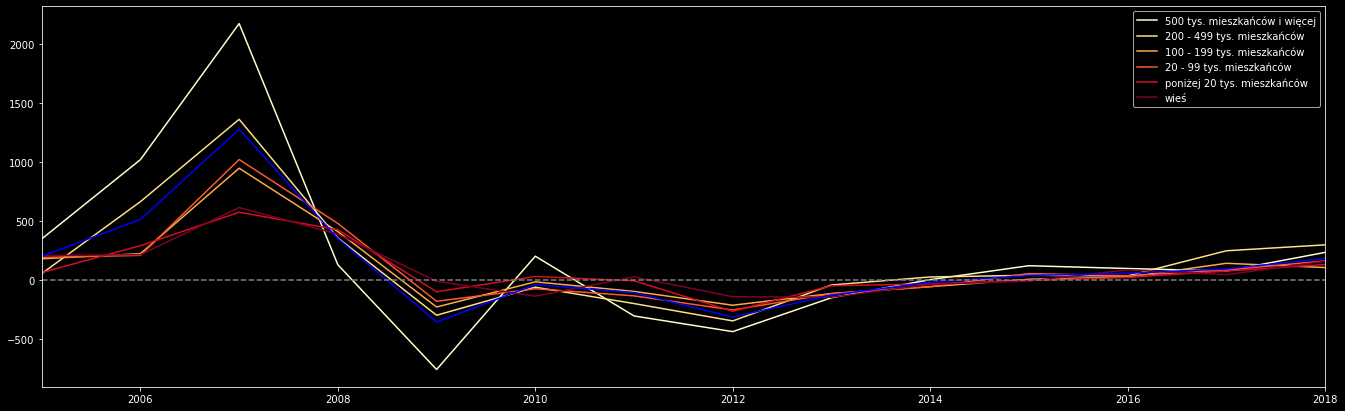

In [27]:
# For whole PL and for different levels of urbanization
klasy = ['500 tys. mieszkańców i więcej', '200 - 499 tys. mieszkańców', '100 - 199 tys. mieszkańców',
         '20 - 99 tys. mieszkańców', 'poniżej 20 tys. mieszkańców', 'wieś']

iterations = []
for i in range(len(lisy)-1):
    iterations.append([lisy[i], lisy[i+1]])

data = mm
Y = ['cena_m2']
X_num = ['constant','powierzchnia_użytkowa']
X_cat = ['rok','województwo','rok_budowy','klasa_miejscowości']

# Whole PL
index_PL = []
for i in iterations:
    temp_data = data.loc[data.rok.isin(i)] 
    dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
    exog = temp_data[X_num].join(dum, how='left')
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    time_param = reg.params['rok_'+str(i[1])]
    index_PL.append(time_param)

# By levels of urbanization
X_cat.remove('klasa_miejscowości')
urb_lev_index = pd.DataFrame(index = lisy[1:])
observations = pd.DataFrame()
R2s = []
for klasa in klasy:
    prams_collector = []
    nobs_collector = []
    for i in iterations:
        temp_data = data.loc[(data.rok.isin(i)) & (data.klasa_miejscowości == klasa)]
        dum = pd.get_dummies(temp_data[X_cat], columns = X_cat, drop_first=True)
        exog = temp_data[X_num].join(dum, how='left')
        exog = exog.loc[:, (exog != 0).any(axis=0)].dropna(axis=1)
        reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
#         print(reg.summary())
        params = reg.params[2]
        prams_collector.append(params)    
        nobs_collector.append(reg.nobs)
        R2s.append(reg.rsquared)
    urb_lev_index[klasa] = prams_collector
    observations[klasa] = nobs_collector

# Plot
fig, ax = plt.subplots(figsize=(23,7))
urb_lev_index.plot(cmap='YlOrRd', ax=ax,xlim=[lisy[1], lisy[-1]])
ax.plot(lisy[1:], index_PL, color='b', label='PL')
ax.plot(lisy[1:], [0]*len(index_PL),'--', color='grey')
# ax.set_ylabel = lisy

# Mean of inde over the years
d = urb_lev_index.mean()
d['PL'] = np.mean(index_PL)
print(d)

# Number of observation in each period and level of urbanization
# observations

# R2s

# PREDICTIONS

## LM pooled

## LM YoY

In [6]:
Y = ['cena_m2']
lm_X_num = ['constant','powierzchnia_użytkowa', 'liczba_pięter']
lm_X_cat = ['rok','województwo','rok_budowy','klasa_miejscowości','prawo_do_lokalu']

lm_interact_1 = ['województwo_mazowieckie', 'województwo_pomorskie']
# interact_1 = ['województwo_'+x for x in województwo_order]
lm_interact_2 = ['klasa_miejscowości_'+x for x in klasa_miejscowości_order]

In [64]:
# Whole PL
data = lm

lm_models = []
observations = []
observations_inter = pd.DataFrame()
for i in lisy:
    lm_X_num_adjust = lm_X_num.copy()
    if i not in range(2006,2015):
        lm_X_num_adjust.remove('liczba_pięter')
    temp_data = data.loc[data.rok == i, Y+lm_X_num_adjust+lm_X_cat ].dropna(axis=0)
    dum_for_inter = pd.get_dummies(temp_data[lm_X_cat], columns = lm_X_cat)
    interactions = interact(dum_for_inter, list1= lm_interact_1, list2=lm_interact_2)
    dum = pd.get_dummies(temp_data[lm_X_cat], columns = lm_X_cat, drop_first=True)
    exog = temp_data[lm_X_num_adjust].join([dum, interactions], how='left')
    exog = exog.loc[:, (exog != 0).any(axis=0)].dropna(axis=1)
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    lm_models.append(reg)
    observations.append(reg.nobs)
    observations_inter[i] = interactions.sum()

# saving lm_models
for i in range(len(lisy)):
    lm_models[i].save('Prediction models/lm_' + str(lisy[i]) + '.model')

## LM to BBGD

In [7]:
# Loading models from files
lm_models = [sm.load('Prediction models/lm_' + str(lisy[i]) + '.model') for i in range(len(lisy))]

# Creating dummies and interaction terms in BBGD
dum_for_inter = pd.get_dummies(bbgd[lm_X_cat], columns = lm_X_cat)
interactions = interact(dum_for_inter, list1= lm_interact_1, list2=lm_interact_2)
dum = pd.get_dummies(bbgd[lm_X_cat], columns = lm_X_cat, drop_first=True)
bbgd = bbgd.join([dum, interactions], how='left')
dum_inter_col = dum.columns.append(interactions.columns)

# Pridicting prices
for i in range(len(lm_models)):
    if lisy[i] in bbgd.rok.unique():
        model = lm_models[i]
        col = model.params.index
        to_estimate_mask = (bbgd.rodzaj_budynku == 'wielorodzinny') & (bbgd.rok == lisy[i])
        bbgd.loc[to_estimate_mask, 'predict_cena_m2'] = model.predict(bbgd[col].loc[to_estimate_mask])

# deleting variables made for regression
bbgd = bbgd[bbgd.columns.drop(dum_inter_col)]

## LM YoY result

## BM pooled

## BM YoY

In [8]:
Y = ['cena_m2']
bm_X_num = ['constant','powierzchnia_użytkowa']
bm_X_cat = ['rok', 'województwo', 'klasa_miejscowości', 'rok_budowy', 'rodzaj_budynku','sieć_ciepłownicza', 'sieć_gazowa']

bm_interact_1 = ['województwo_mazowieckie', 'województwo_pomorskie']
# interact_1 = ['województwo_'+x for x in województwo_order]
bm_interact_2 = ['klasa_miejscowości_'+x for x in klasa_miejscowości_order]

In [93]:
data = bm

# Whole PL
bm_models = []
observations = []
observations_inter = pd.DataFrame()
for i in lisy:
    bm_X_num_adjust = bm_X_num.copy()
    temp_data = data.loc[data.rok == i, Y+bm_X_num_adjust+bm_X_cat ].dropna(axis=0)
    dum_for_inter = pd.get_dummies(temp_data[bm_X_cat], columns = bm_X_cat)
    interactions = interact(dum_for_inter, list1= bm_interact_1, list2=bm_interact_2)
    dum = pd.get_dummies(temp_data[bm_X_cat], columns = bm_X_cat, drop_first=True)
    exog = temp_data[bm_X_num_adjust].join([dum, interactions], how='left')
    exog = exog.loc[:, (exog != 0).any(axis=0)].dropna(axis=1)
    reg = sm.OLS(endog=temp_data[Y], exog=exog , missing='drop').fit()
    bm_models.append(reg)
    observations.append(reg.nobs)
    observations_inter[i] = interactions.sum()
    
# saving bm_models
for i in range(len(lisy)):
    bm_models[i].save('Prediction models/bm_' + str(lisy[i]) + '.model')

## BM YoY result

## BM to BBGD

In [9]:
# Predicting BM
# Loading models from files
bm_models = [sm.load('Prediction models/bm_' + str(lisy[i]) + '.model') for i in range(len(lisy))]

# Creating dummies and interaction terms in BBGD
dum_for_inter = pd.get_dummies(bbgd[bm_X_cat], columns = bm_X_cat)
interactions = interact(dum_for_inter, list1= bm_interact_1, list2=bm_interact_2)
dum = pd.get_dummies(bbgd[bm_X_cat], columns = bm_X_cat, drop_first=True)
bbgd = bbgd.join([dum, interactions], how='left')
dum_inter_col = dum.columns.append(interactions.columns)

# Pridicting prices
for i in range(len(bm_models)):
    if lisy[i] in bbgd.rok.unique():
        model = bm_models[i]
        col = model.params.index
        to_estimate_mask = (bbgd.rodzaj_budynku.isin(['wolnostojący','szeregowy i bliźniaczy'])) & (bbgd.rok == lisy[i])
        bbgd.loc[to_estimate_mask, 'predict_cena_m2'] = model.predict(bbgd[col].loc[to_estimate_mask])

# deleting variables made for regression
bbgd = bbgd[bbgd.columns.drop(dum_inter_col)]

# DISTRIBUTIONS

In [10]:
# CAlculating the total walue of the apartment
bbgd['wartość_mieszkania'] = bbgd.predict_cena_m2 * bbgd.powierzchnia_użytkowa

# turning GD with 0 as imputed price to Nan
bbgd.loc[bbgd.wartość_mieszkania == 0, 'wartość_mieszkania'] = np.nan

# # Deleting all Nanvalues.
bbgd.drop(bbgd.loc[bbgd.wartość_mieszkania.isna()].index, inplace=True)

In [ ]:
# To Do

# To to count all non-owners and set their wealth to 0 

# add number of people

# Substract the debt 

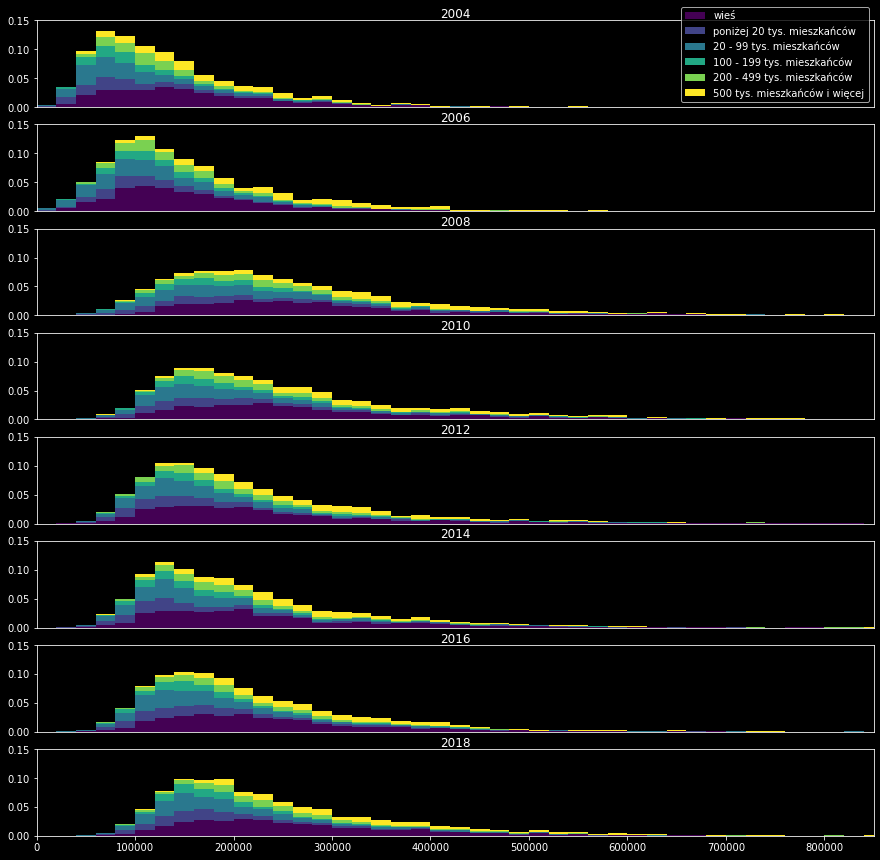

In [222]:
fig, axs = plt.subplots(len(lisy2), figsize=(15,15))
colors = plt.cm.viridis(np.linspace(0, 1, 6))
xlim = 800000
ylim = 0.15
bin_width = 20000
order = klasa_miejscowości_order.copy()
order.reverse()

for i in range(len(lisy2)):
    plot_dat = []
    plot_dat_weights = []
    max_val=0
    for klas in order:
        temp = bbgd.loc[(bbgd.rok==lisy2[i]) & (bbgd.klasa_miejscowości == klas)].wartość_mieszkania.reset_index(drop=True)
        if temp.max() > max_val:
            max_val = temp.max()
        plot_dat.append(temp)
        plot_dat_weights.append(bbgd.loc[(bbgd.rok==lisy2[i]) & (bbgd.klasa_miejscowości == klas)].waga_norm.reset_index(drop=True))
    axs[i].hist(x=plot_dat, weights=plot_dat_weights, color=colors, stacked=True, label=order, bins=w_bins(0,bin_width,max_val))
    axs[i].set_xlim((0, 850000))
    axs[i].set_ylim((0, ylim))
    axs[i].set_title(str(lisy2[i]))
    if i == 0:
        axs[i].legend(order)
    if i != len(lisy2)-1:
        axs[i].axes.get_xaxis().set_visible(False)

In [67]:
from statsmodels.formula.api import ols

In [311]:
y=bbgd.wartość_mieszkania
x=sm.add_constant(pd.get_dummies(bbgd.klasa_miejscowości, drop_first=True))
sample_weight = bbgd.waga
model = ols('wartość_mieszkania ~ C(klasa_miejscowości)', data=bbgd.loc[bbgd.rok==2004]).fit()

print(model.summary())

aov_table = sm.stats.anova_lm(model, typ=2)
display(anova_table(aov_table))

                            OLS Regression Results                            
Dep. Variable:     wartość_mieszkania   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     137.0
Date:                Sat, 25 Jul 2020   Prob (F-statistic):          6.38e-137
Time:                        15:43:44   Log-Likelihood:                -67253.
No. Observations:                5232   AIC:                         1.345e+05
Df Residuals:                    5226   BIC:                         1.346e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(klasa_miejscowości),5.871801e+12,5.0,1.174360e+12,137.023304,6.377145e-137,0.115903,0.115038
Residual,4.478951e+13,5226.0,8.570514e+09,NaN,NaN,NaN,NaN


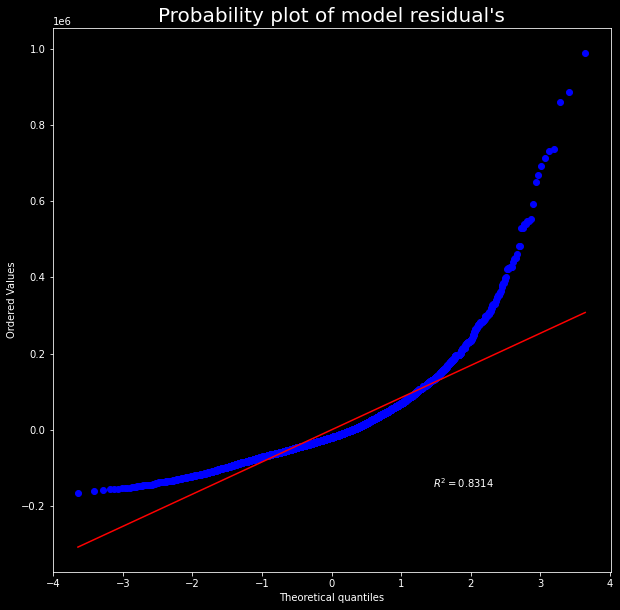

In [312]:
# real and fitted values
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [280]:
# Gausian model with weights using GLM
rok = 2004
sample_weight = bbgd.loc[bbgd.rok==rok].waga
y=bbgd.loc[bbgd.rok==rok].wartość_mieszkania
x=sm.add_constant(pd.get_dummies(bbgd.loc[bbgd.rok==rok].klasa_miejscowości, drop_first=True))

Gausian_model = sm.GLM(y, x, family=sm.families.Gaussian(), freq_weights= sample_weight).fit()

print(Gausian_model.summary())

# Anova doesnt work with GLM
# sm.stats.anova_lm(Gausian_model, typ=2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:     wartość_mieszkania   No. Observations:                 5232
Model:                            GLM   Df Residuals:                  8687224
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                      8.1363e+09
Method:                          IRLS   Log-Likelihood:            -1.1145e+08
Date:                Sat, 25 Jul 2020   Deviance:                   7.0682e+16
Time:                        14:30:37   Pearson chi2:                 7.07e+16
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### ANOVA step by step

In [283]:
# Prototype for ANOVA, all years together
# Weighted wealth data
ww = sm.stats.DescrStatsW(bbgd.wartość_mieszkania, weights=bbgd.waga.round(0))
# Total summ of squares
ss_t = ww.sumsquares
# Info about groups
collector = pd.DataFrame(index=klasa_miejscowości_order, columns=['mean','n','ss'])
for kat in klasa_miejscowości_order:
    temp = bbgd.loc[bbgd.klasa_miejscowości == kat]
    dsw = sm.stats.DescrStatsW(temp.wartość_mieszkania, weights=temp.waga.round(0))
    collector.at[kat, 'mean'] = dsw.mean
    collector.at[kat, 'n'] = dsw.nobs
    collector.at[kat, 'ss'] = dsw.sumsquares
display(collector)
# Error sum of squars
ss_err = collector.ss.sum()
# error mean of squares
ms_err = collector.ss.sum() / collector.n.sum()-6
# Model sum of squres
ss_m = (collector['mean']-ww.mean).apply(lambda x: x*x).multiply(collector.n).sum()
# model mean of square
ms_m = ss_m / 5

,mean,n,ss
500 tys. mieszkańców i więcej,312927,1.08072e+07,3.58664e+17
200 - 499 tys. mieszkańców,216649,7.83445e+06,1.27034e+17
100 - 199 tys. mieszkańców,179681,6.53517e+06,7.54578e+16
20 - 99 tys. mieszkańców,177245,1.46671e+07,1.74934e+17
poniżej 20 tys. mieszkańców,179138,9.59008e+06,1.28119e+17
wieś,232564,2.36476e+07,4.02279e+17


,500 tys. mieszkańców i więcej,200 - 499 tys. mieszkańców,100 - 199 tys. mieszkańców,20 - 99 tys. mieszkańców,poniżej 20 tys. mieszkańców,wieś
2004,194319,126128,107431,107620,105780,161232
2006,282645,171688,135545,120835,128967,155253
2008,385937,259796,206536,212660,227169,292234
2010,361521,244450,222202,216811,223025,286879
2012,311964,223225,201797,191508,176832,234794
2014,301580,217620,176235,183518,175605,231867
2016,313842,223051,183614,182936,186171,233445
2018,347548,266284,208326,198697,198282,261949


,500 tys. mieszkańców i więcej,200 - 499 tys. mieszkańców,100 - 199 tys. mieszkańców,20 - 99 tys. mieszkańców,poniżej 20 tys. mieszkańców,wieś
2004,1.8057e+10,4.03127e+09,3.47013e+09,5.61631e+09,4.5205e+09,9.2524e+09
2006,3.46084e+10,1.56166e+10,4.12421e+09,5.10836e+09,6.08587e+09,6.91592e+09
2008,3.96707e+10,1.94817e+10,1.0489e+10,1.29792e+10,1.76328e+10,2.30039e+10
2010,3.57118e+10,1.41917e+10,2.18865e+10,1.68275e+10,2.22465e+10,2.31001e+10
2012,2.94263e+10,1.3752e+10,1.43584e+10,1.41082e+10,1.48478e+10,1.77187e+10
2014,2.85036e+10,1.46215e+10,8.73552e+09,1.1078e+10,1.05577e+10,1.37042e+10
2016,2.48917e+10,1.35419e+10,8.04113e+09,9.48699e+09,9.35625e+09,1.157e+10
2018,3.11502e+10,1.83409e+10,1.1168e+10,9.14415e+09,8.65603e+09,1.24684e+10


,MS_factor,MS_error,F_test
2004,13020333886863296,8136332569,NaN
2006,10676976582697836,11160196567,NaN
2008,11197908162541036,21351078072,NaN
2010,8025293571875718,22504429383,NaN
2012,3119738498891170,17549846752,NaN
2014,3287813495486812,14690586635,NaN
2016,3760480800527438,12728948373,NaN
2018,6060042167258376,14459546354,NaN


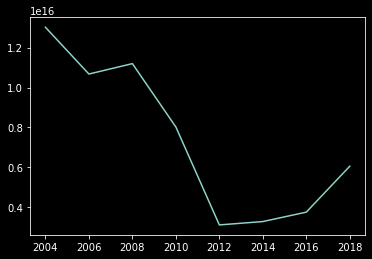

In [300]:
# Full ANOVA across time and levels of urbanisation

ANOVA = pd.DataFrame(index=lisy2, columns=['MS_factor','MS_error','F_test'])
groups_means = pd.DataFrame(index=lisy2, columns=klasa_miejscowości_order)
groups_variance = pd.DataFrame(index=lisy2, columns=klasa_miejscowości_order)

for y in lisy2:   
    collector = pd.DataFrame(index=klasa_miejscowości_order, columns=['mean','n','ss','var'])
    for kat in klasa_miejscowości_order:
        temp = bbgd.loc[(bbgd.klasa_miejscowości == kat) & (bbgd.rok == y)]
        dsw = sm.stats.DescrStatsW(temp.wartość_mieszkania, weights=temp.waga.round(0))

        bbgd.loc[(bbgd.klasa_miejscowości == kat) & (bbgd.rok == y), 'wartość_mieszkania_klas_demean'] = bbgd.loc[(bbgd.klasa_miejscowości == kat) & (bbgd.rok == y), 'wartość_mieszkania']-dsw.mean  
    
        collector.at[kat, 'mean'] = dsw.mean
        collector.at[kat, 'n'] = dsw.nobs
        collector.at[kat, 'ss'] = dsw.sumsquares
        collector.at[kat, 'var'] = dsw.var
        
    groups_means.loc[y, klasa_miejscowości_order] = collector['mean']
    groups_variance.loc[y, klasa_miejscowości_order] = collector['var']
    ANOVA.at[y, 'MS_factor'] = (collector['mean']-ww.mean).apply(lambda x: x*x).multiply(collector.n).sum() / 5
    ANOVA.at[y, 'MS_error'] = collector.ss.sum() / (collector.n.sum()-6)

display(groups_means, groups_variance)
show_nosci(ANOVA)
# ANOVA

ANOVA.MS_factor.plot()

In [295]:
# Tesing the normality of error terms
test_for_normality = pd.DataFrame(columns = ['JB', 'JBp-value', 'skew', 'kurtosis'], index=lisy2)

for y in lisy2:
    temp = bbgd.loc[bbgd.rok == y]
    dsw = sm.stats.DescrStatsW(temp.wartość_mieszkania_klas_demean, weights=temp.waga.round(0))
    test_for_normality.loc[y] = sm.stats.stattools.jarque_bera(dsw.asrepeats())
    
test_for_normality

,JB,JBp-value,skew,kurtosis
2004,6.94719e+07,0,2.48303,15.9332
2006,6.52819e+08,0,4.04028,43.5809
2008,4.38783e+07,0,2.23524,12.7237
2010,6.84121e+07,0,2.5571,15.4561
2012,1.28216e+08,0,3.0158,20.4796
2014,4.677e+07,0,2.34161,12.9489
2016,4.27584e+07,0,2.24599,12.3735
2018,6.12498e+07,0,2.20174,14.8402


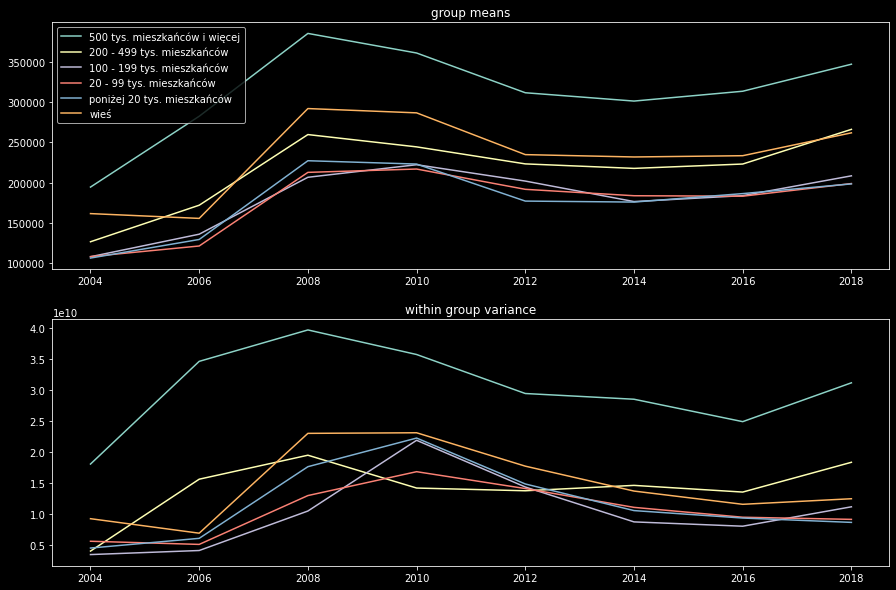

In [253]:
fig, [ax1,ax2] = plt.subplots(2,figsize=(15,10))
groups_means.plot(ax=ax1)
ax1.set_title('group means')

groups_variance.plot(ax=ax2)
ax2.set_title('within group variance')
ax2.legend().set_visible(False)

In [307]:
collector.ss.sum() / (collector.n.sum()-6)

0.17562232000102923

,500 tys. mieszkańców i więcej,200 - 499 tys. mieszkańców,100 - 199 tys. mieszkańców,20 - 99 tys. mieszkańców,poniżej 20 tys. mieszkańców,wieś
2004,12.0012,11.6404,11.463,11.3942,11.3731,11.8274
2006,12.4008,11.8926,11.7194,11.5254,11.6155,11.8194
2008,12.7473,12.3626,12.1438,12.1508,12.1931,12.4753
2010,12.693,12.3192,12.179,12.1585,12.1622,12.4489
2012,12.544,12.21,12.1051,12.0291,11.9385,12.2409
2014,12.4993,12.1881,11.9803,11.9938,11.9444,12.2411
2016,12.5582,12.2172,12.0279,12.0117,12.0228,12.2662
2018,12.6566,12.3948,12.1589,12.1082,12.1054,12.389


,500 tys. mieszkańców i więcej,200 - 499 tys. mieszkańców,100 - 199 tys. mieszkańców,20 - 99 tys. mieszkańców,poniżej 20 tys. mieszkańców,wieś
2004,0.33576,0.202825,0.234488,0.373417,0.417453,0.338789
2006,0.288103,0.282924,0.192606,0.396156,0.304395,0.281658
2008,0.231932,0.196456,0.178983,0.2248,0.275285,0.212675
2010,0.200228,0.159505,0.221706,0.232269,0.275518,0.228622
2012,0.194974,0.199257,0.193859,0.236963,0.253684,0.238129
2014,0.220385,0.179576,0.17923,0.234072,0.244959,0.22257
2016,0.183954,0.180042,0.16974,0.19537,0.2136,0.18747
2018,0.194707,0.179333,0.154255,0.169842,0.174385,0.176101


,MS_factor,MS_error,F_test
2004,84007084609056032,0,NaN
2006,88492758593609888,0,NaN
2008,88911093989961168,0,NaN
2010,87570553902859552,0,NaN
2012,87029496615643184,0,NaN
2014,89770881685252096,0,NaN
2016,91849825834643248,0,NaN
2018,89077324507932128,0,NaN


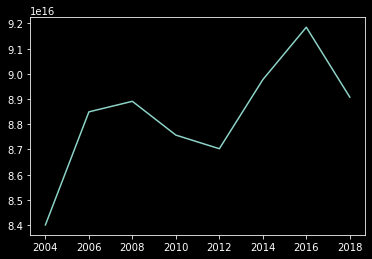

In [302]:
# Using logarythyms of flat value
# Full ANOVA across time and levels of urbanisation

bbgd['ln_wartość_mieszkania'] = np.log(bbgd.wartość_mieszkania)

ANOVA = pd.DataFrame(index=lisy2, columns=['MS_factor','MS_error','F_test'])
groups_means = pd.DataFrame(index=lisy2, columns=klasa_miejscowości_order)
groups_variance = pd.DataFrame(index=lisy2, columns=klasa_miejscowości_order)

for y in lisy2:   
    collector = pd.DataFrame(index=klasa_miejscowości_order, columns=['mean','n','ss','var'])
    for kat in klasa_miejscowości_order:
        temp = bbgd.loc[(bbgd.klasa_miejscowości == kat) & (bbgd.rok == y)]
        dsw = sm.stats.DescrStatsW(temp.ln_wartość_mieszkania, weights=temp.waga.round(0))

        bbgd.loc[(bbgd.klasa_miejscowości == kat) & (bbgd.rok == y), 'ln_wartość_mieszkania_klas_demean'] = bbgd.loc[(bbgd.klasa_miejscowości == kat) & (bbgd.rok == y), 'ln_wartość_mieszkania']-dsw.mean  
    
        collector.at[kat, 'mean'] = dsw.mean
        collector.at[kat, 'n'] = dsw.nobs
        collector.at[kat, 'ss'] = dsw.sumsquares
        collector.at[kat, 'var'] = dsw.var
        
    groups_means.loc[y, klasa_miejscowości_order] = collector['mean']
    groups_variance.loc[y, klasa_miejscowości_order] = collector['var']
    ANOVA.at[y, 'MS_factor'] = (collector['mean']-ww.mean).apply(lambda x: x*x).multiply(collector.n).sum() / 5
    ANOVA.at[y, 'MS_error'] = collector.ss.sum() / (collector.n.sum()-6)

display(groups_means, groups_variance)
show_nosci(ANOVA)
# ANOVA

ANOVA.MS_factor.plot()


In [355]:
# Tesing the normality of error terms
test_for_normality = pd.DataFrame(columns = ['JB', 'JBp-value', 'skew', 'kurtosis'], index=lisy2)

for y in lisy2:
    temp = bbgd.loc[bbgd.rok == y]
    dsw = sm.stats.DescrStatsW(temp.ln_wartość_mieszkania_klas_demean, weights=temp.waga.round(0)).asrepeats()
    test_for_normality.loc[y] = sm.stats.stattools.jarque_bera(dsw)
    
test_for_normality

,JB,JBp-value,skew,kurtosis
2004,25881.1,0,-0.0323994,3.25943
2006,511874,0,-0.248053,4.04706
2008,107672,0,0.16468,3.41542
2010,446055,0,0.458051,3.58558
2012,599403,0,0.513291,3.73795
2014,281831,0,0.357171,3.46726
2016,232339,0,0.316507,3.43169
2018,193197,0,0.299051,3.38162


In [322]:
sm.stats.stattools.jarque_bera(bbgd.loc[bbgd.rok==2008, 'ln_wartość_mieszkania_klas_demean'])

(77.04248188749918,
 1.8639644368703715e-17,
 0.17804456197017143,
 3.4015094194355946)

(232338.6093974141, 0.0, 0.31650722626949646, 3.431692545885483)

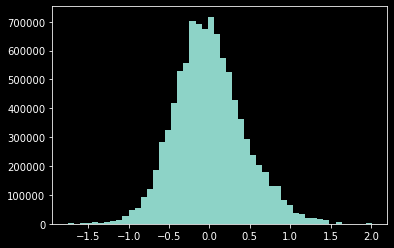

In [354]:
temp = bbgd.loc[bbgd.rok==2016]

plt.hist(sm.stats.DescrStatsW(temp.ln_wartość_mieszkania_klas_demean, weights=temp.waga.round(0)).asrepeats(), bins=50)

sm.stats.stattools.jarque_bera(sm.stats.DescrStatsW(temp.ln_wartość_mieszkania_klas_demean, weights=temp.waga.round(0)).asrepeats())

In [343]:
stats.jarque_bera(temp.ln_wartość_mieszkania_klas_demean)

Jarque_beraResult(statistic=135.56390362648133, pvalue=0.0)

In [13]:
import researchpy as rp

df = pd.read_csv("https://raw.githubusercontent.com/researchpy/Data-sets/master/difficile.csv")
df.drop('person', axis= 1, inplace= True)

# Recoding value from numeric to string
df['dose'].replace({1: 'placebo', 2: 'low', 3: 'high'}, inplace= True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dose    15 non-null     object
 1   libido  15 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 244.0+ bytes


In [14]:
df

,dose,libido
0,placebo,3
1,placebo,2
2,placebo,1
3,placebo,1
4,placebo,4
5,low,5
6,low,2
7,low,4
8,low,2
9,low,3


In [40]:
df.groupby('dose')

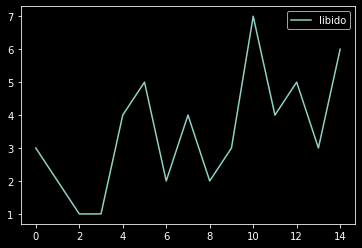

In [24]:
df.plot()

In [15]:
rp.summary_cont(df['libido'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,libido,15.0,3.4667,1.7674,0.4563,2.4879,4.4454


In [43]:
rp.summary_cont(df.groupby('dose').libido)

,N,Mean,SD,SE,95% Conf.,Interval
dose,,,,,,
high,5,5.0,1.5811,0.7071,3.0368,6.9632
low,5,3.2,1.3038,0.5831,1.5811,4.8189
placebo,5,2.2,1.3038,0.5831,0.5811,3.8189


In [17]:
import scipy.stats as stats

stats.f_oneway(df.loc[df['dose'] == 'high', 'libido'],
               df.loc[df['dose'] == 'low', 'libido'],
               df.loc[df['dose'] == 'placebo', 'libido'])

F_onewayResult(statistic=5.11864406779661, pvalue=0.024694289538222603)

In [61]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('libido ~ C(dose)', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 libido   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.119
Date:                Fri, 24 Jul 2020   Prob (F-statistic):             0.0247
Time:                        21:56:15   Log-Likelihood:                -24.683
No. Observations:                  15   AIC:                             55.37
Df Residuals:                      12   BIC:                             57.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.0000      0

c:\users\awersang\appdata\local\programs\python\python38-32\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [62]:
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(dose),20.133333,2.0,5.118644,0.024694
Residual,23.600000,12.0,NaN,NaN


In [23]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(dose),20.133333,2.0,10.066667,5.118644,0.024694,0.460366,0.354486
Residual,23.600000,12.0,1.966667,NaN,NaN,NaN,NaN


# REPOSITORY